### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [1]:
import numpy as np

example_matrix = np.array([[1.5, 0.5], [0.5, 1.5]])
sum_squares = (example_matrix**2).sum()

input_probabilities = []
for x in example_matrix:
  for y in x:
    input_probabilities.append((y**2)/sum_squares)
input_probabilities

[0.45, 0.05, 0.05, 0.45]

as an example, whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

Note that the eigenvalues and the corresponding eigenvectors obtained by classical PCA are given by
$$\lambda_1=2, u_1=[1,1]^T$$
$$\lambda_2=1, u_2=[−1,1]^T.$$

Note: $[1, 0]^T = |0〉$ and $[0, 1]^T = |1〉.$ 

When we take a threshold τ=1.1 for eigenvalues, the eigenvalue in binary $|λ_1〉=|10〉$ and the corresponding eigenvector $|u_1〉=[1,1]^T=\frac{1}{\sqrt{2}}|0〉+\frac{1}{\sqrt{2}}|1〉$ are considered as principal components. Therefore, the output of the proposed algorithm should be given by

$$\begin{aligned}
\left|\psi_A^{\prime}\right\rangle &=\left|\lambda_1\right\rangle\left|u_1\right\rangle\left|u_1\right\rangle \\
&=|10\rangle \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \\
&=\frac{1}{2}|1000\rangle+\frac{1}{2}|1001\rangle+\frac{1}{2}|1010\rangle+\frac{1}{2}|1011\rangle .
\end{aligned}$$

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

resolution = 2

input_register = QuantumRegister(len(example_matrix), name="input_state")
eigenvalues_register = QuantumRegister(resolution, name="eigenvalues")
ancilla_register = QuantumRegister(1, name="ancilla")

qupca_circuit = QuantumCircuit(2)


In [3]:
thetas = [2 * np.arcsin(np.sqrt(input_probabilities[1]+input_probabilities[2])), 2 * np.arcsin(np.sqrt(input_probabilities[0]+input_probabilities[3]))]
thetas

[0.6435011087932844, 2.498091544796509]

In [4]:
qupca_circuit = QuantumCircuit(2)

qupca_circuit.h(0)
qupca_circuit.cry(thetas[0], control_qubit = 0, target_qubit = 1)
qupca_circuit.x(0)
qupca_circuit.cry(thetas[1], control_qubit = 0, target_qubit = 1)
# qupca_circuit.measure_all()

qupca_circuit.draw()


┌───┐              ┌───┐              
q_0: ┤ H ├──────■───────┤ X ├──────■───────
     └───┘┌─────┴──────┐└───┘┌─────┴──────┐
q_1: ─────┤ Ry(0.6435) ├─────┤ Ry(2.4981) ├
          └────────────┘     └────────────┘

In [5]:
from qiskit import Aer, transpile, execute
from qiskit.visualization import plot_histogram

backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(qupca_circuit, backend=backend))
job.result().get_counts()


{'00': 0.45, '01': 0.05, '10': 0.05, '11': 0.45}

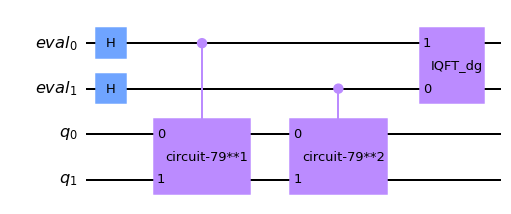

In [6]:
from qiskit.circuit.library import PhaseEstimation
# from qiskit.algorithms import EstimationProblem
# problem = EstimationProblem(qupca_circuit, [0])
pe = PhaseEstimation(2, qupca_circuit)
pe.decompose(reps=1).draw("mpl")

In [9]:
import numpy as np
from scipy.linalg import expm
from qiskit.quantum_info.operators import Operator

matrix = np.array([[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 2, 0], [0, 0, 0, 3]])
print(matrix)
U  = expm(matrix*(np.pi*1j/2))
np.set_printoptions(suppress=True)
print(U)
operator_U = Operator(U)
operator_U

[[0 0 0 0]
 [0 1 0 0]
 [0 0 2 0]
 [0 0 0 3]]
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+1.j -0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.-0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -0.-1.j]]


Operator([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+1.j, -0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j, -1.+0.j,  0.-0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, -0.-1.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [11]:
qupca_circuit.append(operator_U, [0, 1])
qupca_circuit.decompose().draw()

┌─────────┐                            ┌───────────┐                   »
q_0: ──┤ U2(0,π) ├────■────────────────────■──┤ U3(π,0,π) ├──■────────────────»
     ┌─┴─────────┴─┐┌─┴─┐┌──────────────┐┌─┴─┐├───────────┤┌─┴─┐┌────────────┐»
q_1: ┤ Ry(0.32175) ├┤ X ├┤ Ry(-0.32175) ├┤ X ├┤ Ry(1.249) ├┤ X ├┤ Ry(-1.249) ├»
     └─────────────┘└───┘└──────────────┘└───┘└───────────┘└───┘└────────────┘»
«              ┌───────────────┐         ┌───────────────┐     
«q_0: ──■──────┤ U3(0,-π/2,-π) ├─────────┤ U3(0,-π/2,-π) ├─────
«     ┌─┴─┐┌───┴───────────────┴────┐┌───┴───────────────┴────┐
«q_1: ┤ X ├┤ U3(0,-2.6224,-0.51915) ├┤ U3(0,-2.6224,-0.51915) ├
«     └───┘└────────────────────────┘└────────────────────────┘